In [20]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

In [21]:
df = pd.read_csv('../data/ML.csv')
df

,Date,Freight_Price,Oil_Price,crisis_COVID-19 oil crash,crisis_Dot-com crash,crisis_Global financial crisis,crisis_Inflation and rate hikes,crisis_Oil price collapse,crisis_None,war_Arab Spring,war_Crimea crisis,war_Iraq War,war_Ukraine War,war_None,sanctions_Iran sanctions,sanctions_Russia sanctions,sanctions_None,pandemic_COVID-19,pandemic_None,month,year,quarter,is_year_start,is_year_end,sin_month,cos_month,Freight_Lag1,Freight_Lag2,Oil_Lag1,Oil_Lag2,Freight_SMA_3,Oil_SMA_3,has_crisis,has_war,has_sanctions,has_pandemic
0,2002-08-01,728.0,27.47,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,8,2002,3,0,0,-8.660254e-01,-5.000000e-01,742.0,733.0,25.44,25.58,734.333333,26.163333,1,0,0,0
1,2002-09-01,683.0,28.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,9,2002,3,0,0,-1.000000e+00,-1.836970e-16,728.0,742.0,27.47,25.44,717.666667,27.220000,1,0,0,0
2,2002-10-01,721.0,25.72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,10,2002,4,0,0,-8.660254e-01,5.000000e-01,683.0,728.0,28.75,27.47,710.666667,27.313333,1,0,0,0
3,2002-11-01,886.0,25.16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,11,2002,4,0,0,-5.000000e-01,8.660254e-01,721.0,683.0,25.72,28.75,763.333333,26.543333,0,0,0,0
4,2002-12-01,1033.0,28.66,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,12,2002,4,0,0,-2.449294e-16,1.000000e+00,886.0,721.0,25.16,25.72,880.000000,26.513333,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2024-11-01,663.0,71.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,11,2024,4,0,0,-5.000000e-01,8.660254e-01,523.0,554.0,72.81,71.77,580.000000,72.140000,0,1,1,0
268,2024-12-01,625.0,74.24,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12,2024,4,0,0,-2.449294e-16,1.000000e+00,663.0,523.0,71.84,72.81,603.666667,72.963333,0,1,1,0
269,2025-01-01,662.0,75.67,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1,2025,1,1,0,5.000000e-01,8.660254e-01,625.0,663.0,74.24,71.84,650.000000,73.916667,0,1,1,0
270,2025-02-01,670.0,72.81,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2,2025,1,0,0,8.660254e-01,5.000000e-01,662.0,625.0,75.67,74.24,652.333333,74.240000,0,1,1,0


In [22]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df.sort_values("Date", inplace=True)
df.set_index("Date", inplace=True)
df.index.freq = 'MS'
df = df[['Freight_Price', 'Oil_Price', 'has_war', 'has_crisis', 'sin_month', 'cos_month']]
df = df.dropna()
df

,Freight_Price,Oil_Price,has_war,has_crisis,sin_month,cos_month
Date,,,,,,
2002-08-01,728.0,27.47,0,1,-8.660254e-01,-5.000000e-01
2002-09-01,683.0,28.75,0,1,-1.000000e+00,-1.836970e-16
2002-10-01,721.0,25.72,0,1,-8.660254e-01,5.000000e-01
2002-11-01,886.0,25.16,0,0,-5.000000e-01,8.660254e-01
2002-12-01,1033.0,28.66,0,0,-2.449294e-16,1.000000e+00
...,...,...,...,...,...,...
2024-11-01,663.0,71.84,1,0,-5.000000e-01,8.660254e-01
2024-12-01,625.0,74.24,1,0,-2.449294e-16,1.000000e+00
2025-01-01,662.0,75.67,1,0,5.000000e-01,8.660254e-01


In [23]:
X = df.drop(columns=['Freight_Price'])
y = df['Freight_Price']

In [24]:
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

In [25]:
param_grid = {
    'num_leaves': [15, 31, 50, 100],
    'max_depth': [4, 10, 20],
    'learning_rate': [0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
}
lgb_wo_lags = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search_wo_lags = GridSearchCV(estimator=lgb_wo_lags, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_wo_lags.fit(X_train, y_train)
print("Лучшие параметры: ", grid_search_wo_lags.best_params_)
best_model_wo_lags = grid_search_wo_lags.best_estimator_
y_pred_wo_lags = best_model_wo_lags.predict(X_test)
print("MSE без лагов: ", mean_squared_error(y_test, y_pred_wo_lags))
print("MAE без лагов: ", mean_absolute_error(y_test, y_pred_wo_lags))
print("RMSE без лагов: ", root_mean_squared_error(y_test, y_pred_wo_lags))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 5
[LightGBM] [Info] Start training from score 803.929245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

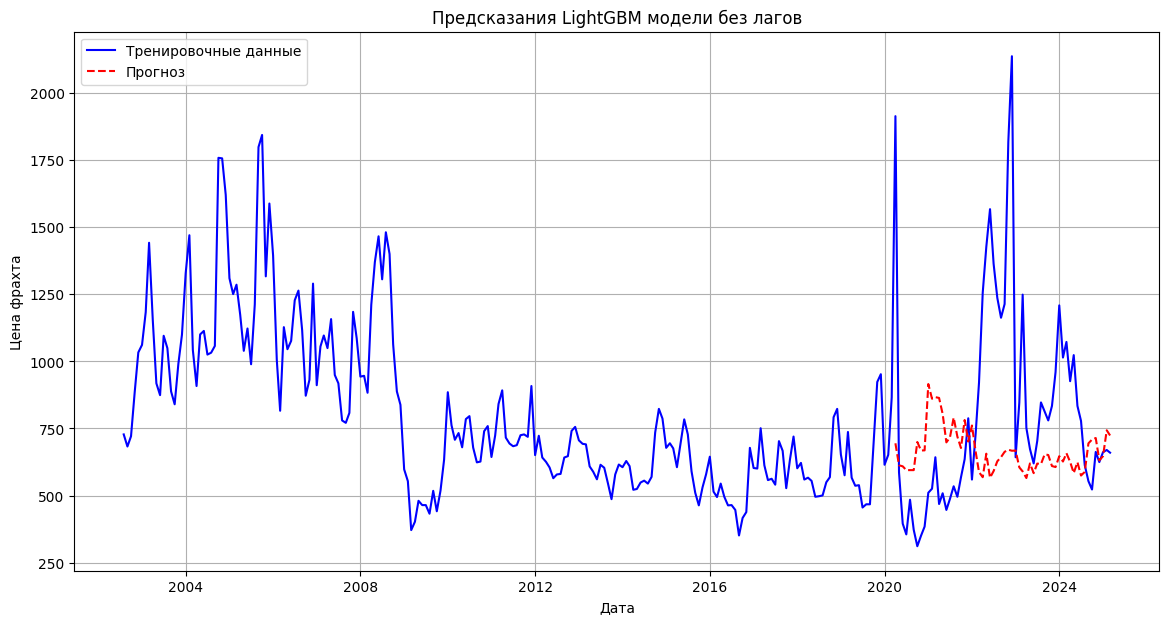

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(y_test.index, y_pred_wo_lags, label='Прогноз', color='red', linestyle='--')
plt.title('Предсказания LightGBM модели без лагов')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
for lag in [1, 2, 6, 12, 24]:
    df[f'Freight_Price(t-{lag})'] = df['Freight_Price'].shift(lag)
    df[f'Oil_Price(t-{lag})'] = df['Oil_Price'].shift(lag)
df = df.dropna()
X = df.drop(columns=['Freight_Price'])
y = df['Freight_Price']
X_train = X[:-60]
X_test = X[-60:]
y_train = y[:-60]
y_test = y[-60:]

In [29]:
lgb_w_lags = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
grid_search_w_lags = GridSearchCV(estimator=lgb_w_lags, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_w_lags.fit(X_train, y_train)
print("Лучшие параметры: ", grid_search_w_lags.best_params_)
best_model_w_lags = grid_search_w_lags.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 716
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 15
[LightGBM] [Info] Start training from score 775.563830
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [34]:
# Новый итеративный прогноз с заполнением лагов прогноза новыми значениями

# Тестовый итеративный прогноз на последние 60 месяцев (тестовый период)
forecast_horizon = 60
last_date = X_test.index[0]  # начало тестового периода
# Инициализируем историю лагов из последних 24 значений тренировочного набора
freight_history = list(y_train[-24:])
iterative_predictions = []
current_date = last_date

for i in range(forecast_horizon):
    fp_t1 = freight_history[-1]
    fp_t2 = freight_history[-2] if len(freight_history) >= 2 else freight_history[0]
    fp_t6 = freight_history[-6] if len(freight_history) >= 6 else freight_history[0]
    fp_t12 = freight_history[-12] if len(freight_history) >= 12 else freight_history[0]
    fp_t24 = freight_history[-24] if len(freight_history) >= 24 else freight_history[0]
    
    current_date = current_date + pd.DateOffset(months=1)
    month = current_date.month
    sin_month = np.sin(2 * np.pi * month / 12)
    cos_month = np.cos(2 * np.pi * month / 12)
    # Берем неизменными значения остальных признаков из последних строк тренировочного набора
    oil_price = X_train.iloc[-1]['Oil_Price']
    oil_price_t1 = X_train.iloc[-1]['Oil_Price(t-1)']
    oil_price_t2 = X_train.iloc[-1]['Oil_Price(t-2)']
    oil_price_t6 = X_train.iloc[-1]['Oil_Price(t-6)']
    oil_price_t12 = X_train.iloc[-1]['Oil_Price(t-12)']
    oil_price_t24 = X_train.iloc[-1]['Oil_Price(t-24)']
    has_war = X_train.iloc[-1]['has_war']
    has_crisis = X_train.iloc[-1]['has_crisis']
    
    new_features = {
        'Oil_Price': oil_price,
        'has_war': has_war,
        'has_crisis': has_crisis,
        'sin_month': sin_month,
        'cos_month': cos_month,
        'Freight_Price(t-1)': fp_t1,
        'Freight_Price(t-2)': fp_t2,
        'Freight_Price(t-6)': fp_t6,
        'Freight_Price(t-12)': fp_t12,
        'Freight_Price(t-24)': fp_t24,
        'Oil_Price(t-1)': oil_price_t1,
        'Oil_Price(t-2)': oil_price_t2,
        'Oil_Price(t-6)': oil_price_t6,
        'Oil_Price(t-12)': oil_price_t12,
        'Oil_Price(t-24)': oil_price_t24
    }
    new_X = pd.DataFrame([new_features], index=[current_date])
    pred = best_model_w_lags.predict(new_X)[0]
    iterative_predictions.append(pred)
    freight_history.append(pred)

forecast_series = pd.Series(iterative_predictions,
    index=pd.date_range(start=X_test.index[1], periods=forecast_horizon, freq='MS'))
print("Тестовый итеративный прогноз для последних 60 месяцев:")
print(forecast_series)

Тестовый итеративный прогноз для последних 60 месяцев:
2020-05-01    751.511830
2020-06-01    680.804298
2020-07-01    716.433119
2020-08-01    645.071441
2020-09-01    593.592939
2020-10-01    580.235292
2020-11-01    639.431972
2020-12-01    715.627742
2021-01-01    711.028807
2021-02-01    663.210876
2021-03-01    652.495719
2021-04-01    628.406784
2021-05-01    602.041812
2021-06-01    591.081422
2021-07-01    568.530578
2021-08-01    557.964833
2021-09-01    523.878921
2021-10-01    507.588043
2021-11-01    540.829373
2021-12-01    578.678584
2022-01-01    649.935464
2022-02-01    647.240822
2022-03-01    632.214199
2022-04-01    637.491027
2022-05-01    610.429860
2022-06-01    584.332104
2022-07-01    560.183127
2022-08-01    517.836066
2022-09-01    491.802095
2022-10-01    489.555647
2022-11-01    538.841277
2022-12-01    556.907058
2023-01-01    547.288483
2023-02-01    534.235635
2023-03-01    532.468542
2023-04-01    520.331506
2023-05-01    518.732726
2023-06-01    525.37

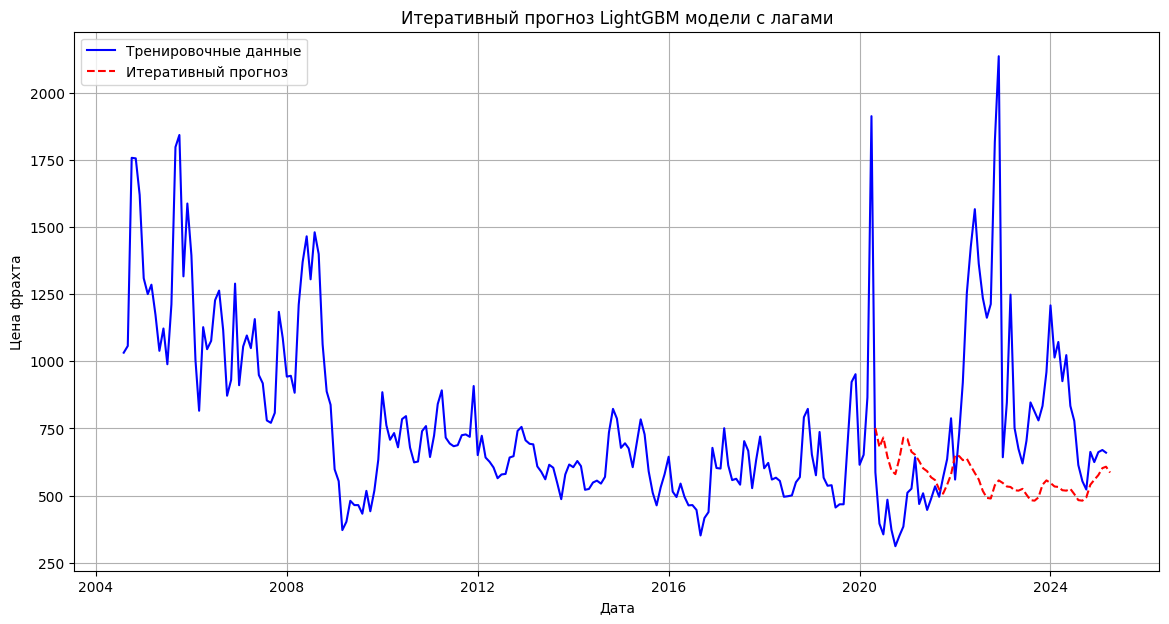

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(y.index, y, label='Тренировочные данные', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Итеративный прогноз', color='red', linestyle='--')
plt.title('Итеративный прогноз LightGBM модели с лагами')
plt.xlabel('Дата')
plt.ylabel('Цена фрахта')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
mse_w_lags = mean_squared_error(y_test, forecast_series)
mae_w_lags = mean_absolute_error(y_test, forecast_series)
rmse_w_lags = root_mean_squared_error(y_test, forecast_series)
print("MSE с лагами: ", mse_w_lags)
print("MAE с лагами: ", mae_w_lags)
print("RMSE с лагами: ", rmse_w_lags)

MSE с лагами:  225474.1930719902
MAE с лагами:  336.06684379161953
RMSE с лагами:  474.84122933038384
